In [ ]:
import torch
from pathlib import Path

data_type = ['xyz', 'feature_dc_index', 'quant_cholesky_elements']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dict_keys(['xyz', 'feature_dc_index', 'quant_cholesky_elements'])

In [ ]:
import math
def preprocess(data):
    result = []
    for X in data: 
        X_processed = X
        if X.shape[1] < 3:
            pad = torch.zeros(X.shape[0], 3 - X.shape[1], device=X.device)
            # 保证有3通道
            X_processed = torch.cat([X, pad], dim=1) 
        
        N, C = X_processed.shape

        # ---- Step 1: 原始 sqrt-based 尺寸 ----
        H = W = int(math.ceil(math.sqrt(N)))

        # ---- Step 2: 向上取整到 8 的倍数 ----
        def ceil_to_multiple(x, base=8):
            return int(math.ceil(x / base) * base)
        
        H = ceil_to_multiple(H, 8)
        W = ceil_to_multiple(W, 8)

        # ---- Step 3: padding 以填满 H×W ----
        pad_length = H * W - N
        if pad_length > 0:
            X_processed = torch.cat(
                [X_processed, torch.zeros(pad_length, C, device=X.device)], dim=0
            )

        # ---- Step 4: reshape 为 [1, C, 1, H, W] ----
        X_processed = X_processed.T.view(C, 1, H, W)
        #TODO: There might be some problem with mask for cholesky
        mask = torch.zeros(1, 1, 1, H, W, device=X.device)
        mask[:, :, :, :int(math.sqrt(N)), :int(math.sqrt(N))] = 1
        result.append((X_processed.unsqueeze(0), mask))  # shape: (1, C, 1, H, W)
    
    return result

def convert_to_original(X, original_N, original_C):
    C, _, H, W = X.shape[1:]  # X shape: (1, C, 1, H, W)
    N = H * W
    X = X.view(C, N).T  # shape: (N, C)
    X = X[:original_N, :original_C] 
    return X

torch.Size([1, 3, 1, 56, 56])

In [ ]:
from models.guassian_iv_vae import IV_VAE
import io, contextlib

z_dim = 32
dim = 128

def init_vae():
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        vae = IV_VAE(z_dim, dim).to(device=device, dtype=torch.float32)
    return vae


IV_VAE(
  (model): VAutoencoder3d(
    (encoder): Encoder3d(
      (conv1): First_Sep_Conv3d(
        (conv_2d): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_3d): Group_Causal_Conv3d(3, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      )
      (downsamples): Sequential(
        (0): Sep_ResidualBlock(
          (residual): Sequential(
            (0): Sep_RMS_norm()
            (1): SiLU()
            (2): Sep_Conv3d(
              (conv_2d): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (conv_3d): Group_Causal_Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            )
            (3): Sep_RMS_norm()
            (4): SiLU()
            (5): Dropout(p=0.0, inplace=False)
            (6): Sep_Conv3d(
              (conv_2d): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (conv_3d): Group_Causal_Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
            )
   

In [ ]:
import copy
def chamfer_distance(pcd1, pcd2):
    if pcd1.ndim == 2:  # [N, 2]
        pcd1 = pcd1.unsqueeze(0)
        pcd2 = pcd2.unsqueeze(0)
    diff_1 = torch.cdist(pcd1, pcd2)
    min_1, _ = diff_1.min(dim=2)
    min_2, _ = diff_1.min(dim=1)
    return (min_1.mean(dim=1) + min_2.mean(dim=1)).mean()

def tensor_to_pointcloud(tensor):
    """
    tensor: [1, 3, 1, H, W]
    return: [N, 2]
    """
    B, C, D, H, W = tensor.shape
    tensor = tensor.view(B, C, -1)     # [1, 3, H*W]
    tensor = tensor.squeeze(0).T       # [H*W, 3]
    tensor = tensor.unsqueeze(0)  # [1, H*W, 3]
    return tensor[..., :2]  # return [1, N, 2]

def train(vae, input, mask, device, epochs=2000, lr=1e-4):
    """
    input: [1, 3, 1, H, W] 
    """
    vae = vae.to(device=device, dtype=torch.float32)
    vae.requires_grad_(True)
    optimizer = torch.optim.AdamW(vae.parameters(), lr=lr)

    best_loss = 1.0
    for epoch in range(1, epochs + 1):
        vae.train()
        optimizer.zero_grad()

        # ---- Forward ----
        z = vae.encode(input)              
        recon = vae.decode(z) 

        # ---- Loss ----
        # recon_pcd = tensor_to_pointcloud(recon)
        # target_pcd = tensor_to_pointcloud(input)
        # loss = chamfer_distance(target_pcd, recon_pcd)
        loss = torch.nn.functional.mse_loss(recon, input) 
        
        # ---- Backward ----
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss or epoch == 1:
            best_loss = loss.item()
            best_model = copy.deepcopy(vae.state_dict())

        if epoch % 20 == 0 or epoch == 1:
            print(f"\r[Train] epoch {epoch:4d}/{epochs} | loss={loss.item():.6f}", end='')
    vae.load_state_dict(best_model)
    vae.requires_grad_(False)
    print(f"\n[Result]Best loss: {best_loss:.6f}")
    return best_model


In [ ]:
import matplotlib.pyplot as plt

def plot_result(target, recon, is_float):
    input_pcd = tensor_to_pointcloud(target)
    recon_pcd = tensor_to_pointcloud(recon)
    pcd1 = input_pcd[0].detach().cpu()
    pcd2 = recon_pcd[0].detach().cpu()
    
    diff = torch.cdist(pcd1.unsqueeze(0), pcd2.unsqueeze(0))[0]
    min_idx = diff.argmin(dim=1)
    
    plt.figure(figsize=(6, 6))
    if is_float:
        plt.scatter(pcd1[:, 0], pcd1[:, 1], s=10, c='blue', label='Input')
        plt.scatter(pcd2[:, 0], pcd2[:, 1], s=10, c='red', label='Reconstructed')
    else:
        plt.scatter(torch.round(pcd1[:, 0]), torch.round(pcd1[:, 1]), s=10, c='blue', label='Input')
        plt.scatter(torch.round(pcd2[:, 0]), torch.round(pcd2[:, 1]), s=10, c='red', alpha=0.5, label='Reconstructed')
    
    for i in torch.linspace(0, len(pcd1)-1, 20).long():
        plt.plot(
            [pcd1[i, 0], pcd2[min_idx[i], 0]],
            [pcd1[i, 1], pcd2[min_idx[i], 1]],
            'gray', linewidth=0.5, alpha=0.4
        )
    
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [ ]:
def save_patch_dict(model_states, save_path: Path, patch_idx):
    save_path = Path(save_path)
    for i in range(3):
        d = data_type[i]
        dir_path = save_path / f"{d}"
        if not dir_path.exists():
            dir_path.mkdir(parents=True, exist_ok=True)
        
        model_state = model_states[i]
        file_path = dir_path / f"{patch_idx:02}_zdim{z_dim}_dim{dim}.pth"
        torch.save(model_state, file_path)

[Train] epoch 3000/3000 | loss=0.000002
[Result]Best loss: 0.000002
torch.Size([1, 3, 1, 56, 56])


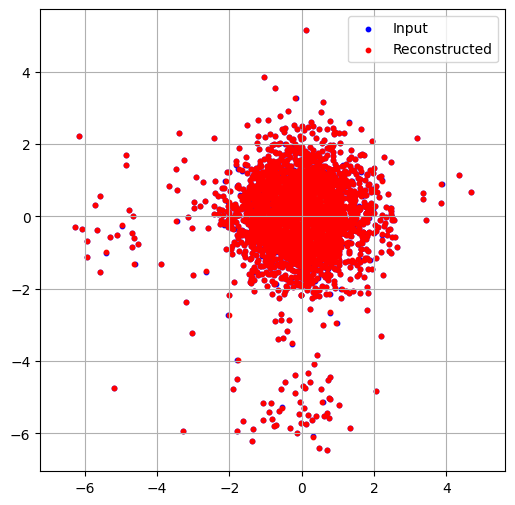

Final Reconstruction Loss (rounded MSE): 0.000002
[Train] epoch 3000/3000 | loss=0.000033
[Result]Best loss: 0.000004
torch.Size([1, 3, 1, 56, 56])


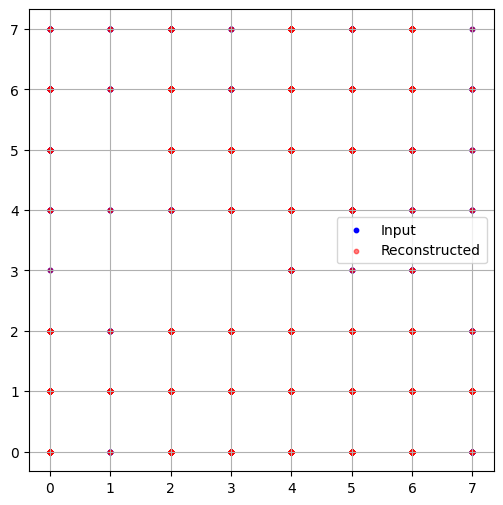

Final Reconstruction Loss (rounded MSE): 0.000000
[Train] epoch 10000/10000 | loss=0.0017436
[Result]Best loss: 0.000127
torch.Size([1, 3, 1, 56, 56])


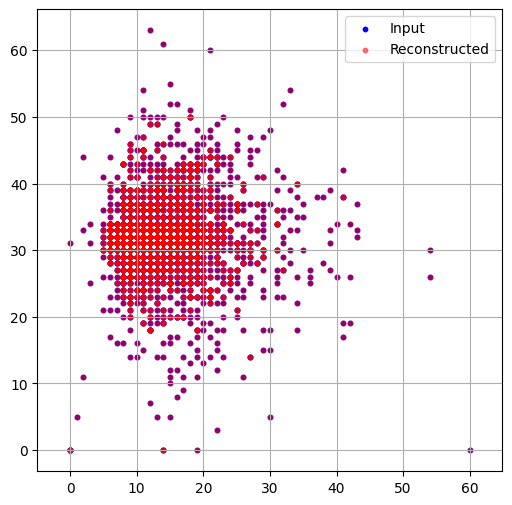

Final Reconstruction Loss (rounded MSE): 0.000000


In [ ]:
num_patches = 16 
num_pts = 2048
patch_models = [] 
model_dest = Path.cwd().joinpath("ckpt/tile") 

for patch in range(num_patches):
    file_path = Path.cwd() / f"input/tile/comp_{patch:02}.pth"
    comp_dict = torch.load(file_path) 
    model_save_path = model_dest / f"comp_{patch:02}"

    fields = [comp_dict[d] for d in data_type]

    input_list = preprocess(fields)
    model_states = [None, None, None]

    print(f"=== Training Patch {patch:02} ===")
    for i in range(3):
        if i == 2:
            epoch = 10000
        else:
            epoch = 3000 

        (input, mask) = input_list[i]

        # Train
        vae = init_vae()
        best_model = train(vae, input, mask, device, epochs=epoch)

        # Evaluate
        vae.eval()
        with torch.no_grad():
            z = vae.encode(input)
            recon = vae.decode(z)
            print(recon.shape)
        
        # Round to nearest integer *semantically*, keep float dtype
        if not i == 0:
            input_rounded = torch.round(input)
            recon_rounded = torch.round(recon)
        
            # Compute continuous MSE
            loss = torch.nn.functional.mse_loss(input_rounded, recon_rounded)
            plot_result(input, recon, False)
        else:
            loss = torch.nn.functional.mse_loss(input, recon)
            plot_result(input, recon, True)
        print(f"[Eval] Reconstruction MSE Loss {loss.item():.6f}")
        model_states[i] = best_model
    patch_models.append(copy.deepcopy(model_states))
    save_patch_dict(model_states, model_save_path, patch)

In [ ]:
# reconstructions = {}

# for i in range(3):
#     dtype = data_type[i]
#     model_path = Path.cwd().joinpath(f"ckpt/{dtype}/{file_name}_zdim{z_dim}_dim{dim}.pth")
#     vae.load_state_dict(torch.load(model_path))
#     vae.requires_grad_(False)
#     with torch.no_grad():
#         z = vae.encode(input)
#         recon = vae.decode(z)
#     if i == 2:
#         C = 3
#         recon = torch.round(recon)
#     elif i == 1:
#         recon = torch.round(recon).int()
#     else:
#         C = 2
    
#     reconstructions[dtype] = convert_to_original(recon, num_pts, C)
    
# for key, value in reconstructions.items():
#     print(f"{key} reconstruction shape: {value.shape}")

xyz reconstruction shape: torch.Size([3000, 2])
feature reconstruction shape: torch.Size([3000, 2])
cholesky reconstruction shape: torch.Size([3000, 3])


In [ ]:
# reconstructions

{'xyz': tensor([[ 0.6633, -0.4465],
         [-0.2718,  0.4284],
         [-1.9753,  0.7000],
         ...,
         [ 0.0583,  0.1239],
         [-0.9347,  0.6165],
         [-0.0599, -1.1322]], device='cuda:0'),
 'feature': tensor([[3, 1],
         [5, 1],
         [3, 5],
         ...,
         [2, 1],
         [3, 1],
         [5, 1]], device='cuda:0', dtype=torch.int32),
 'cholesky': tensor([[11., 24., 10.],
         [ 8., 32.,  3.],
         [12., 31., 26.],
         ...,
         [ 8., 33., 26.],
         [ 9., 31., 11.],
         [13., 34., 24.]], device='cuda:0')}

In [ ]:
# comp_dict

{'xyz': tensor([[ 0.6631, -0.4465],
         [-0.2734,  0.4258],
         [-1.9766,  0.6992],
         ...,
         [ 2.4766, -1.0254],
         [-0.7803,  0.5205],
         [ 0.7935,  1.8525]], device='cuda:0', dtype=torch.float16),
 'feature_dc_index': tensor([[3, 1],
         [5, 1],
         [3, 5],
         ...,
         [6, 7],
         [6, 1],
         [4, 1]], device='cuda:0'),
 'quant_cholesky_elements': tensor([[11., 24., 10.],
         [ 8., 32.,  3.],
         [12., 31., 26.],
         ...,
         [ 9., 29., 62.],
         [10., 23., 26.],
         [13., 37.,  6.]], device='cuda:0')}

In [ ]:
# torch.save(reconstructions, Path.cwd().joinpath(f"results/gaussians/{file_name}_zdim{z_dim}_dim{dim}_recon.pth"))